In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


2025-07-18 20:36:06.989787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752852967.198351    1899 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752852967.264521    1899 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752852967.752141    1899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752852967.752274    1899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752852967.752281    1899 computation_placer.cc:177] computation placer alr

In [2]:

DATA_DIR = "dataset"

# Get gesture folders
gesture_labels = ["thanks", "alhumdulillah","come here","salam","what","how are you","I am fine"]
label_to_index = {label: idx for idx, label in enumerate(gesture_labels)}

X = []
y = []

for label in gesture_labels:
    label_path = os.path.join(DATA_DIR, label)
    if not os.path.isdir(label_path):
        continue
    
    for file in os.listdir(label_path):
        if file.endswith(".npy"):
            file_path = os.path.join(label_path, file)
            sequence = np.load(file_path)  # shape: (30, 99)
       
            X.append(sequence)
            y.append(label_to_index[label])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
from sklearn.utils import shuffle
print("X shape:", X.shape)  # (samples, 30, 99)
print("y shape:", y.shape)


X shape: (918, 30, 162)
y shape: (918,)


In [14]:
frame = X[0][0]  # first sample, first frame
print(len(frame))  # should be 162

num_landmarks = len(frame) // 3
print("Number of landmarks in one frame:", num_landmarks)

162
Number of landmarks in one frame: 54


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

def create_lightweight_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.0001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Second Convolutional Block
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Fully Connected Layers
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Example usage
input_shape = (30, 162)  # 30 frames, 126 landmarks (x,y,z)*42 landmarks
num_classes = 7       # Change to your number of classes
model = create_lightweight_model(input_shape, num_classes)

# Mobile-optimized compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_85 (Conv1D)              │ (None, 26, 64)         │        51,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 26, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 9, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,327 (626.28 KB)

 Trainable params: 159,943 (624.78 KB)

 Non-trainable params: 384 (1.50 KB)

In [107]:
# Add these callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4539 - loss: 1.6637

2025-07-15 03:03:00.841302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_transpose_fusion', 4 bytes spill stores, 4 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.4596 - loss: 1.6479 - val_accuracy: 0.2246 - val_loss: 1.8148 - learning_rate: 5.0000e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8783 - loss: 0.5301 - val_accuracy: 0.3043 - val_loss: 1.6528 - learning_rate: 5.0000e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9529 - loss: 0.2299 - val_accuracy: 0.4203 - val_loss: 1.4848 - learning_rate: 5.0000e-04
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9864 - loss: 0.1392 - val_accuracy: 0.7464 - val_loss: 1.2504 - learning_rate: 5.0000e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0866 - val_accuracy: 0.8986 - val_loss: 1.0479 - learning_rate: 5.0000e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0777 - val_accuracy: 0.8696 - val_loss: 0.8919 - learning_rate: 5.0000e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - lo

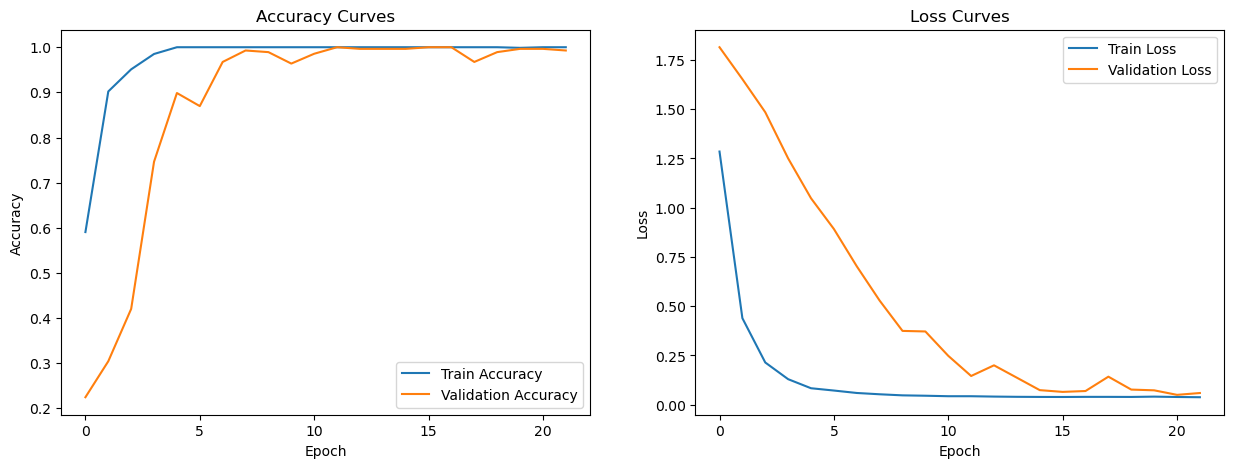

In [108]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

plot_history(history)  # Pass your model's history object

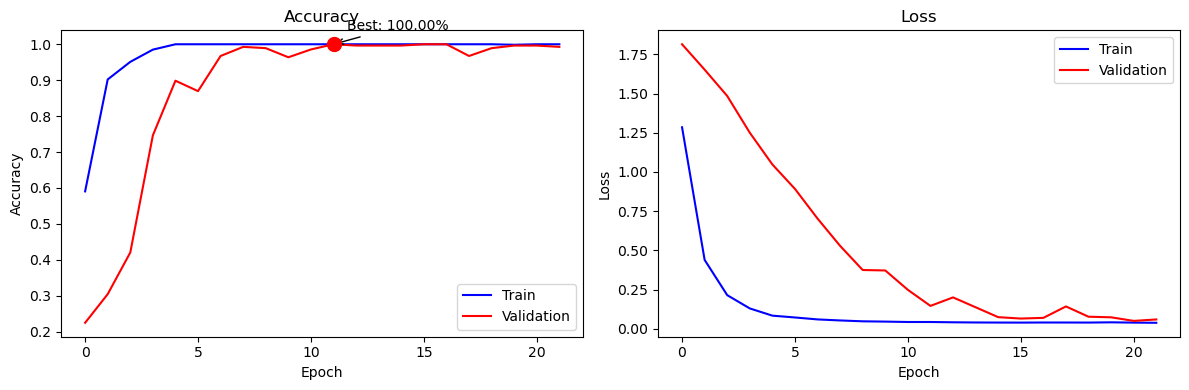

In [109]:
def enhanced_history_plot(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'b-', label='Train')
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation')
    
    # Mark best epoch
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_acc = history.history['val_accuracy'][best_epoch]
    plt.scatter(best_epoch, best_acc, s=100, c='red', zorder=5)
    plt.annotate(f'Best: {best_acc:.2%}',
                 (best_epoch, best_acc),
                 xytext=(10, 10),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'))
    
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b-', label='Train')
    plt.plot(history.history['val_loss'], 'r-', label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

enhanced_history_plot(history)

In [110]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize KFold (stratified to preserve class balance)
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
y_true_all = []
y_pred_all = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Build fresh model (important!)
    model = create_lightweight_model(input_shape=(30, 162), 
                                   num_classes=len(gesture_labels))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        verbose=1)
    
    # Evaluate
    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    fold_accuracies.append(val_acc)
    
    # Store predictions for overall metrics
    y_true_all.extend(y_val)
    y_pred_all.extend(model.predict(X_val).argmax(axis=1))

# Overall performance
print("\nCross-Validation Results:")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.2%} (±{np.std(fold_accuracies):.2%})")


Fold 1/5
Epoch 1/50


/home/mercy/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.4592 - loss: 1.4855 - val_accuracy: 0.1413 - val_loss: 2.6080
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9239 - loss: 0.3261 - val_accuracy: 0.1685 - val_loss: 2.1796
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9663 - loss: 0.1727 - val_accuracy: 0.4457 - val_loss: 1.4145
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9904 - loss: 0.0918 - val_accuracy: 0.6957 - val_loss: 1.0367
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9807 - loss: 0.0973 - val_accuracy: 0.5978 - val_loss: 1.0257
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9973 - loss: 0.0594 - val_accuracy: 0.9239 - val_loss: 0.5030
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9996 - loss: 0.0546 - val_accuracy: 0.8043 - val_loss: 0.6345
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9958 - loss: 0.0519 - val_accuracy: 0.9185 - val_loss: 0.

2025-07-15 03:04:33.198865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_transpose_fusion', 4 bytes spill stores, 4 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.4799 - loss: 1.5630 - val_accuracy: 0.1749 - val_loss: 2.0567
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9168 - loss: 0.3510 - val_accuracy: 0.1803 - val_loss: 1.8503
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9833 - loss: 0.1281 - val_accuracy: 0.4317 - val_loss: 1.4313
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9884 - loss: 0.0955 - val_accuracy: 0.5792 - val_loss: 1.2352
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9885 - loss: 0.0726 - val_accuracy: 0.6393 - val_loss: 1.0142
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9959 - loss: 0.0646 - val_accuracy: 0.6284 - val_loss: 1.0008
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0532 - val_accuracy: 0.8907 - val_loss: 0.4610
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0442 - val_accuracy: 0.9235 - val_loss: 0

2025-07-15 03:04:58.718799: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_transpose_fusion', 4 bytes spill stores, 4 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.5262 - loss: 1.4801 - val_accuracy: 0.2186 - val_loss: 2.2217
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9493 - loss: 0.2333 - val_accuracy: 0.2459 - val_loss: 1.8222
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9766 - loss: 0.1285 - val_accuracy: 0.3825 - val_loss: 1.3846
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9933 - loss: 0.0759 - val_accuracy: 0.4645 - val_loss: 1.1842
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9925 - loss: 0.0718 - val_accuracy: 0.7486 - val_loss: 0.8001
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9917 - loss: 0.0634 - val_accuracy: 0.8634 - val_loss: 0.5987
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9971 - loss: 0.0590 - val_accuracy: 0.8852 - val_loss: 0.4753
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9969 - loss: 0.0506 - val_accuracy: 0.7049 - val_loss: 0.


Classification Report:
               precision    recall  f1-score   support

       thanks       0.99      0.99      0.99       132
alhumdulillah       0.99      0.99      0.99       131
    come here       0.99      0.95      0.97       131
        salam       0.99      0.98      0.99       131
         what       0.97      0.98      0.98       131
  how are you       0.99      1.00      1.00       131
    I am fine       0.97      1.00      0.98       131

     accuracy                           0.99       918
    macro avg       0.99      0.99      0.99       918
 weighted avg       0.99      0.99      0.99       918



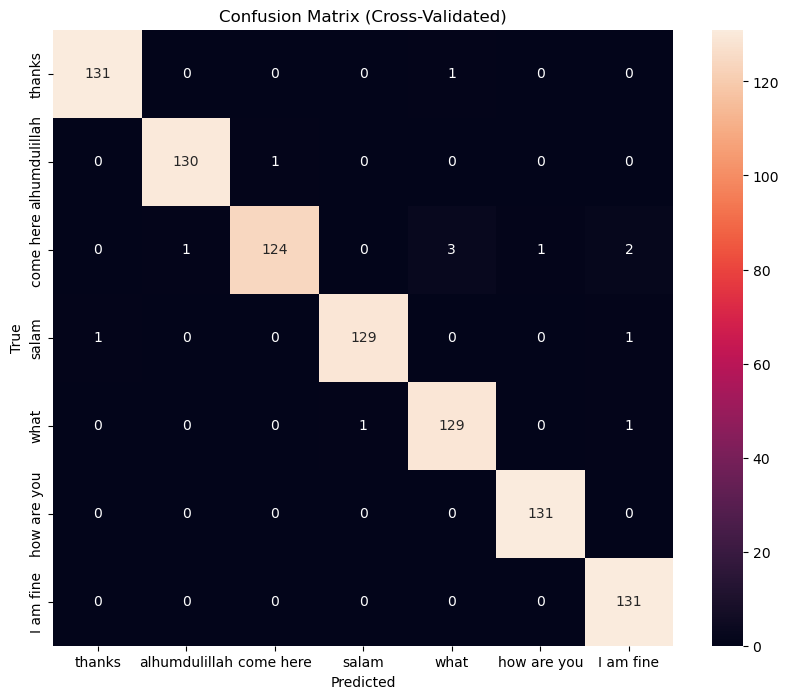

In [111]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=gesture_labels))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=gesture_labels, 
            yticklabels=gesture_labels)
plt.title("Confusion Matrix (Cross-Validated)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Classification Report:
               precision    recall  f1-score   support

       thanks       0.99      0.99      0.99       132
alhumdulillah       0.99      0.99      0.99       131
    come here       0.99      0.95      0.97       131
        salam       0.99      0.98      0.99       131
         what       0.97      0.98      0.98       131
  how are you       0.99      1.00      1.00       131
    I am fine       0.97      1.00      0.98       131

     accuracy                           0.99       918
    macro avg       0.99      0.99      0.99       918
 weighted avg       0.99      0.99      0.99       918



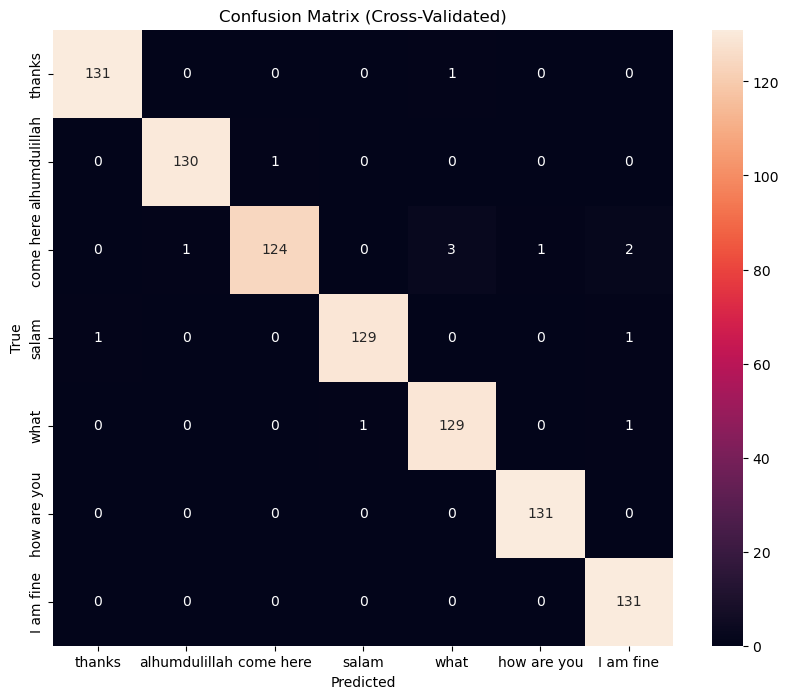

In [112]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=gesture_labels))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=gesture_labels, 
            yticklabels=gesture_labels)
plt.title("Confusion Matrix (Cross-Validated)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

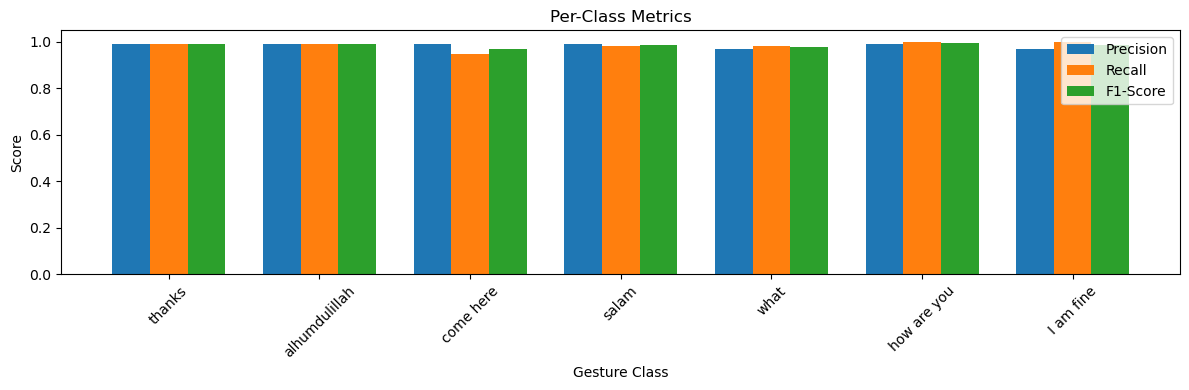

In [113]:
# Get precision, recall, f1 per class
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_true_all, y_pred_all)

# Plot
plt.figure(figsize=(12, 4))
x = np.arange(len(gesture_labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')

plt.xlabel("Gesture Class")
plt.ylabel("Score")
plt.title("Per-Class Metrics")
plt.xticks(x, gesture_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [114]:
model.save("WordModel.keras")

In [5]:
from tensorflow.keras.models import load_model
model = load_model('WordModel.keras') 

I0000 00:00:1752853016.034886    1899 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [15]:
def generate_representative_data(X_train, num_samples=100):
    """Yields input data in correct format for quantization calibration"""
    for i in range(min(num_samples, len(X_train))):
        sample = X_train[i].reshape(1, 30, 162).astype(np.float32)
        yield [sample]

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
          tf.lite.OpsSet.TFLITE_BUILTINS,
          tf.lite.OpsSet.SELECT_TF_OPS 
]

converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

converter.representative_dataset = lambda: generate_representative_data(X_train)

tflite_model = converter.convert()

# Save the TFLite model
with open('Wordmodel.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TFLite model saved as Alphabetmodel.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpa_79hz93/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_79hz93/assets


Saved artifact at '/tmp/tmpa_79hz93'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 162), dtype=tf.float32, name='input_layer_50')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  133495527696240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495527701168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495527924912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495527926672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495527920336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495527922624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495527924208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495528051584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495528054048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495528051056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133495528050352:

/home/mercy/miniconda3/envs/myenv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ TFLite model saved as Alphabetmodel.tflite


W0000 00:00:1752853768.123315    1899 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752853768.123376    1899 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-18 20:49:28.123647: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa_79hz93
2025-07-18 20:49:28.124424: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-18 20:49:28.124456: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpa_79hz93
2025-07-18 20:49:28.134740: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-18 20:49:28.183726: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpa_79hz93
2025-07-18 20:49:28.201677: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 78034 microseconds.
fully_quantize: 0, inference_type: 6, input_i

In [9]:
import cv2
import numpy as np
import tensorflow as tf
import time
from collections import deque
import mediapipe as mp

# Configuration
IP_CAMERA_URL = "http://192.168.100.3:8080/video"
TFLITE_MODEL_PATH = "Wordmodel.tflite"
TARGET_FRAMES = 30  # Must match your training
GESTURE_THRESHOLD = 0.85
GESTURE_LABELS = [
    'alhumdulillah',
    'thanks',
]

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

W0000 00:00:1751260260.942377   32677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751260260.983634   32677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751260261.002746   32686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751260261.069957   32686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [2]:
import cv2
import numpy as np
import mediapipe as mp
from collections import deque
import tensorflow as tf

# ---------- CONFIG ----------
TFLITE_MODEL_PATH = "Wordmodel.tflite"  # Path to your TFLite model
IP_CAM_URL = "http://192.168.100.3:8080/video"
GESTURE_LABELS = [
    'thanks','alhumdulillah'
]
SEQUENCE_LENGTH = 30
CONFIDENCE_THRESHOLD = 0.7
# ----------------------------

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Sequence buffer
sequence = deque(maxlen=SEQUENCE_LENGTH)

# Landmark extraction
def extract_landmarks(frame):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hand_results = hands.process(rgb)
    pose_results = pose.process(rgb)

    if not hand_results.multi_hand_landmarks:
        return None

    hand = hand_results.multi_hand_landmarks[0]
    hand_coords = [coord for lm in hand.landmark for coord in (lm.x, lm.y, lm.z)]

    if pose_results.pose_landmarks:
        pose_coords = [coord for lm in pose_results.pose_landmarks.landmark for coord in (lm.x, lm.y, lm.z)]
    else:
        pose_coords = [0.0] * (33 * 3)

    return np.array(hand_coords + pose_coords, dtype=np.float32), hand, pose_results.pose_landmarks

# Start webcam
cap = cv2.VideoCapture(IP_CAM_URL)
print("🟢 Starting real-time prediction...")

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    result = extract_landmarks(frame)
    if result:
        landmark_vector, hand_lm, pose_lm = result
        sequence.append(landmark_vector)

        # Draw landmarks
        mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)
        if pose_lm:
            mp_drawing.draw_landmarks(frame, pose_lm, mp_pose.POSE_CONNECTIONS)

        if len(sequence) == SEQUENCE_LENGTH:
            input_data = np.expand_dims(np.array(sequence, dtype=np.float32), axis=0)

            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])[0]

            class_id = int(np.argmax(output_data))
            confidence = output_data[class_id]

            if confidence > CONFIDENCE_THRESHOLD:
                label = f"{GESTURE_LABELS[class_id]} ({confidence:.2f})"
            else:
                label = "..."

            cv2.putText(frame, label, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
    else:
        sequence.clear()

    cv2.imshow("TFLite Real-Time Sign Inference", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

cap.release()
cv2.destroyAllWindows()
hands.close()
pose.close()


W0000 00:00:1751261375.406590   33421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751261375.454499   33426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751261375.493533   33429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751261375.558810   33429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


🟢 Starting real-time prediction...


In [3]:
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture("http://192.168.100.3:8080/video")  # or use your IP cam

# Face-related pose landmark indices (nose, eyes, ears, mouth corners, etc.)
face_idxs = [
    mp_pose.PoseLandmark.NOSE,
    mp_pose.PoseLandmark.LEFT_EYE_INNER,
    mp_pose.PoseLandmark.RIGHT_EYE_INNER,
    mp_pose.PoseLandmark.LEFT_EAR,
    mp_pose.PoseLandmark.RIGHT_EAR,
    mp_pose.PoseLandmark.MOUTH_LEFT,
    mp_pose.PoseLandmark.MOUTH_RIGHT
]

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    if results.pose_landmarks:
        print("--- Face Visibility ---")
        for landmark in face_idxs:
            vis = results.pose_landmarks.landmark[landmark].visibility
            name = landmark.name
            print(f"{name}: {vis:.2f}")
            wrist_z = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].z
            print("Relative depth (Z):", wrist_z)

    cv2.imshow("Webcam", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
pose.close()


W0000 00:00:1751261626.610838   33668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751261626.684415   33668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


--- Face Visibility ---
NOSE: 1.00
Relative depth (Z): -1.046800971031189
LEFT_EYE_INNER: 1.00
Relative depth (Z): -1.046800971031189
RIGHT_EYE_INNER: 1.00
Relative depth (Z): -1.046800971031189
LEFT_EAR: 1.00
Relative depth (Z): -1.046800971031189
RIGHT_EAR: 1.00
Relative depth (Z): -1.046800971031189
MOUTH_LEFT: 1.00
Relative depth (Z): -1.046800971031189
MOUTH_RIGHT: 1.00
Relative depth (Z): -1.046800971031189
--- Face Visibility ---
NOSE: 1.00
Relative depth (Z): -0.6857244968414307
LEFT_EYE_INNER: 1.00
Relative depth (Z): -0.6857244968414307
RIGHT_EYE_INNER: 1.00
Relative depth (Z): -0.6857244968414307
LEFT_EAR: 1.00
Relative depth (Z): -0.6857244968414307
RIGHT_EAR: 1.00
Relative depth (Z): -0.6857244968414307
MOUTH_LEFT: 1.00
Relative depth (Z): -0.6857244968414307
MOUTH_RIGHT: 1.00
Relative depth (Z): -0.6857244968414307
--- Face Visibility ---
NOSE: 1.00
Relative depth (Z): -0.7494746446609497
LEFT_EYE_INNER: 1.00
Relative depth (Z): -0.7494746446609497
RIGHT_EYE_INNER: 1.00
R